In [ ]:
#Import bibs

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from matplotlib.patches import Rectangle, Patch



In [20]:
# Load dataset
print(os.getcwd())
file_path = r"../data/adhdata.csv"
df = pd.read_csv(file_path)
print("Dataset shape:", df.shape)
print("Columns:", df.columns)

c:\Users\osoys\Documents\GitHub\ADHD_EEG\notebooks
Dataset shape: (2166383, 21)
Columns: Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID'],
      dtype='object')


In [21]:
# Encode labels
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # ADHD=1, Control=0

# Parameters
sfreq = 128  # Sampling frequency in Hz
window_size = 256  # 2 seconds of data
step_size = 256  # non-overlapping
channels = [col for col in df.columns if col not in ['Class', 'ID']]

X = []
y = []

In [22]:
# Generate PSD feature maps per window
for subject_id in df['ID'].unique():
    subject_data = df[df['ID'] == subject_id][channels].values
    label = df[df['ID'] == subject_id]['Class'].values[0]
    
    for start in range(0, len(subject_data) - window_size, step_size):
        window = subject_data[start:start + window_size]
        psd_matrix = []
        for ch in range(window.shape[1]):
            freqs, psd = welch(window[:, ch], fs=sfreq, nperseg=128)
            psd_matrix.append(psd[:50])  # reduce resolution if needed
        psd_matrix = np.array(psd_matrix)  # shape: (channels, freq_bins)
        X.append(psd_matrix)
        y.append(label)

X = np.array(X)
y = np.array(y)

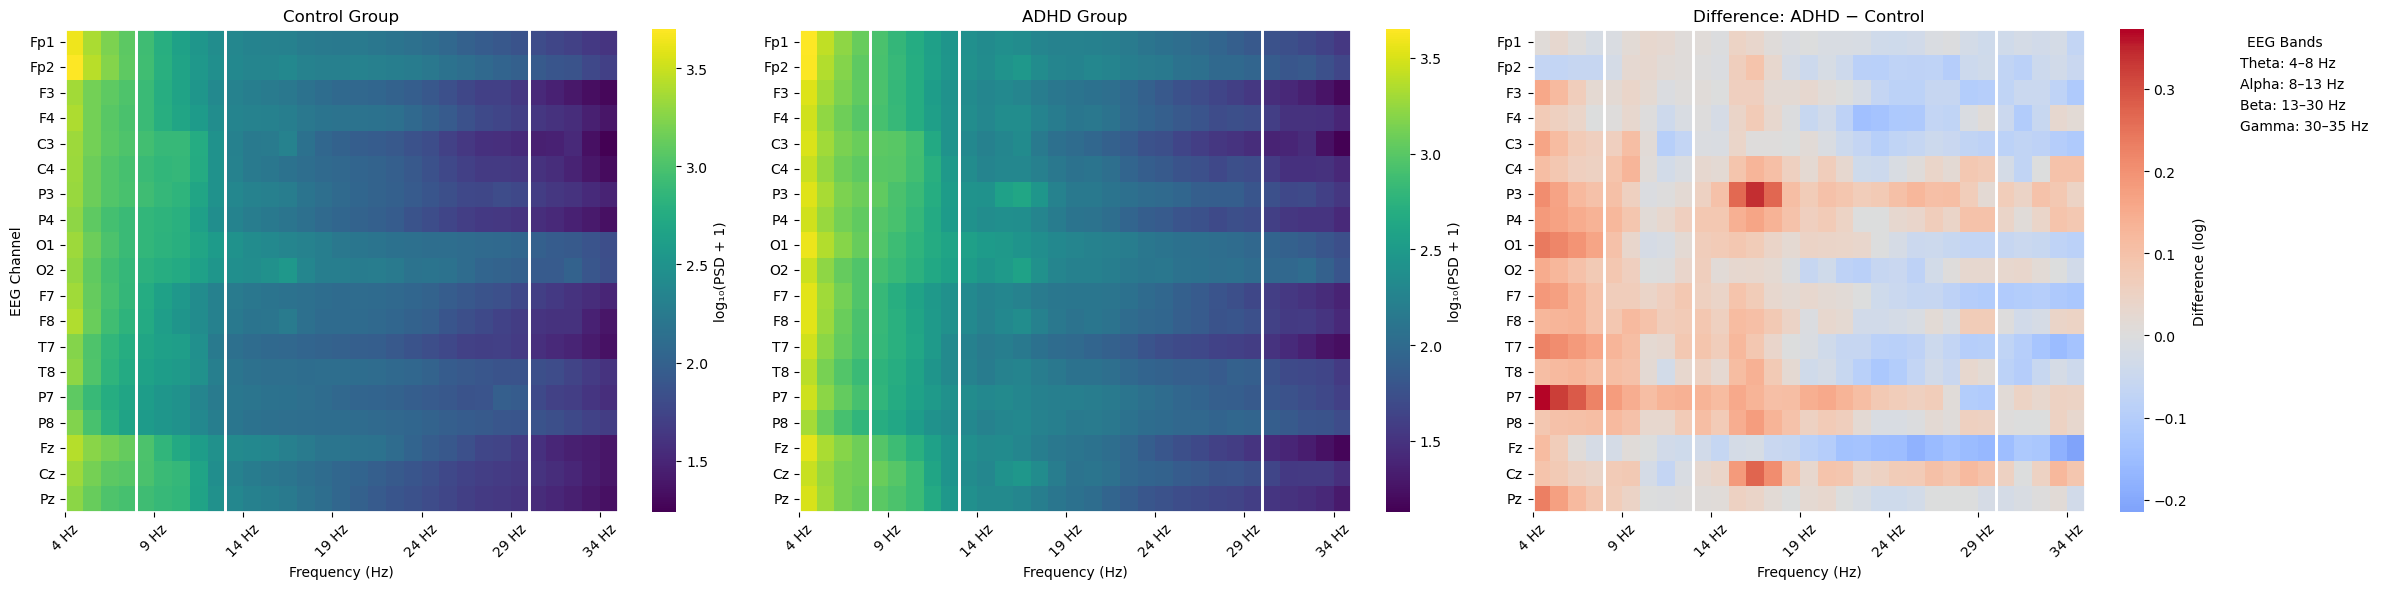

Mean difference per band (ADHD − Control):
  Theta: 0.1117
  Alpha: 0.0388
  Beta : 0.0124
  Gamma: -0.0280


In [ ]:
# Create Heatmap for visualization

# 1. Compute average EEG feature maps per class
adhd_avg    = X[y == 1].mean(axis=0)
control_avg = X[y == 0].mean(axis=0)

# 2. Select bins corresponding to 4–35 Hz (fs=128, nperseg=128 → 1 Hz/Bin)
freq_start, freq_end = 4, 35      # include bins 4..35
adhd_cut    = adhd_avg[:,    freq_start:freq_end]
control_cut = control_avg[:, freq_start:freq_end]

# 3. Apply log-scaling
adhd_log    = np.log10(adhd_cut    + 1)
control_log = np.log10(control_cut + 1)

# 4. Compute difference map
diff = adhd_log - control_log

# 5. Define tick positions & labels for bins (every 5 Hz)
hz_ticks    = np.arange(freq_start, freq_end, 5)    # [4,9,14,19,24,29,34]
tick_bins   = hz_ticks - freq_start                 # [0,5,10,...]
tick_labels = [f"{h} Hz" for h in hz_ticks]

# 6. Define EEG bands in Hz
band_defs_hz = {
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta":  (13, 30),
    "Gamma": (30, freq_end)
}
# convert to bin-relative indices
band_defs = {name: (f0 - freq_start, f1 - freq_start)
             for name, (f0, f1) in band_defs_hz.items()}

# 7. Plot side-by-side heatmaps
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

for ax, data, title, cmap, center in zip(
    axs,
    [control_log, adhd_log, diff],
    ["Control Group",
     "ADHD Group",
     "Difference: ADHD − Control"],
    ['viridis', 'viridis', 'coolwarm'],
    [None, None, 0]
):
    sns.heatmap(
        data,
        ax=ax,
        cmap=cmap,
        center=center,
        yticklabels=channels,
        cbar_kws={"label": "log₁₀(PSD + 1)" if center is None else "Difference (log)"}
    )
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    if ax is axs[0]:
        ax.set_ylabel("EEG Channel")
    else:
        ax.set_ylabel("")
    ax.set_xticks(tick_bins)
    ax.set_xticklabels(tick_labels, rotation=45)

    # 8. Draw rectangular outlines around each EEG band
    n_ch = len(channels)
    for name, (b0, b1) in band_defs.items():
        rect = Rectangle((b0, 0), b1 - b0, n_ch,
                         fill=False, edgecolor='white', linewidth=2)
        ax.add_patch(rect)

# 9. Add a legend for the bands
legend_handles = [
    Patch(facecolor='none',
          edgecolor='white',
          linewidth=2,
          label=f"{name}: {f0}–{f1} Hz")
    for name, (f0, f1) in band_defs_hz.items()
]
# Place legend below the third plot
axs[2].legend(handles=legend_handles,
              loc='upper left',
              bbox_to_anchor=(1.2, 1),
              borderaxespad=0.,
              frameon=False,
              title="EEG Bands")

plt.tight_layout()
plt.show()

# 10. Print mean difference per band
print("Mean difference per band (ADHD − Control):")
for name, (f0, f1) in band_defs_hz.items():
    rel0, rel1 = f0 - freq_start, f1 - freq_start
    val = diff[:, rel0:rel1].mean()
    print(f"  {name:5s}: {val:.4f}")


In [13]:
# Scale feature maps and reshape for CNN
X = X[..., np.newaxis]  # Add channel dimension
scaler = StandardScaler()
X = X.reshape((X.shape[0], -1))
X = scaler.fit_transform(X)
X = X.reshape((-1, len(channels), 50, 1))

y_cat = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Define CNN
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(len(channels), 50, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\osoys\anaconda3\envs\adhd_eeg_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 17, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 24, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       393,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,730 (1.50 MB)

 Trainable params: 393,730 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9755 - loss: 0.0703 - val_accuracy: 0.9702 - val_loss: 0.1183
Epoch 2/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9787 - loss: 0.0595 - val_accuracy: 0.9621 - val_loss: 0.1302
Epoch 3/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9765 - loss: 0.0614 - val_accuracy: 0.9702 - val_loss: 0.1508
Epoch 4/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9790 - loss: 0.0718 - val_accuracy: 0.9643 - val_loss: 0.1333
Epoch 5/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9851 - loss: 0.0433 - val_accuracy: 0.9784 - val_loss: 0.1039
Epoch 6/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9840 - loss: 0.0488 - val_accuracy: 0.9725 - val_loss: 0.1169
Epoch 7/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9810 - loss: 0.0831 - val_accuracy: 0.9688 - val_loss: 0.1059
Epoch 8/15
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9887 - loss: 0.0399 - val_accuracy: 0.

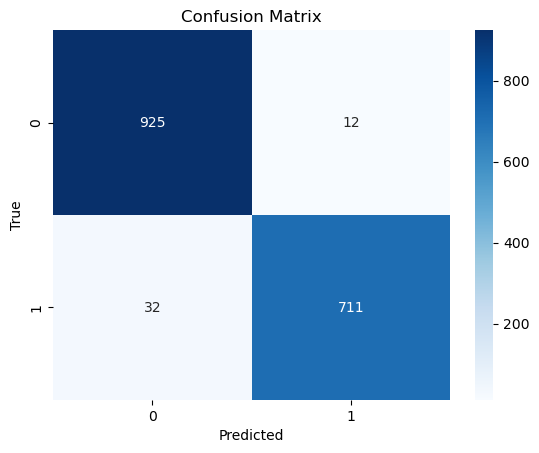

In [16]:
# Train model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# Confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Save model
model.save("../modells/hirnmap_featuremap_cnn.h5")